# Diffusion models

Blog posts/reviews:
- [Lilian Weng's blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Yang Song's blog post](https://yang-song.net/blog/2021/score/)
- [Alex Alemi's blog post](https://blog.alexalemi.com/diffusion.html)
- [Understanding Diffusion Models: A Unified Perspective by Calvin Luo](https://arxiv.org/abs/2208.11970)
  
Relevant papers:
- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)
- [Maximum Likelihood Training of Score-Based Diffusion Models](https://arxiv.org/abs/2101.09258)
- [Variational Diffusion Models](https://arxiv.org/abs/2107.00630)


## Denoising diffusion

Denoising diffusion can be viewed as a hierarchical VAE, with a few restrictions on the architecture:
1. The dimensionality of the latents at different hierarchical levels and the data are the same (although this can be relaxed for latent diffusion).
2. The encoder is not learned; instead, the encoding processes are Markovian $q(x_t\mid x_{t-1})$ and correspond to a Gaussian distributions with mean corresponding to the output of the previous encoding step, $$q\left({x}_t \mid {x}_{t-1}\right)=\mathcal{N}\left(\sqrt{1 - \beta_t}\, {x}_{t-1},\beta_t \mathbb{I}\right)$$
where $\beta_t$ is a fixed or learnable variance schedule, and we've decided that the variance of the latents is preserved at various hierarchies (timesteps). This is the forward diffusion process.
3. The distribution of latents at the final timestep is a standard Gaussian (similar to a regular VAE).

### The forward process

We have $q\left({x}_t \mid {x}_{t-1}\right)=\mathcal{N}\left(\sqrt{1 - \beta_t}\, {x}_{t-1},\beta_t \mathbb{I}\right)$. During training, it will be useful to have a closed-form expression for $q(x_t\mid x_0)$. See Eqs. (61)-(70) of [2208.11970](https://arxiv.org/abs/2208.11970); with $\alpha_t\equiv 1 - \beta_t$ we have
$$q(x_t\mid x_0) = \mathcal N(\sqrt{(\overline{\alpha}_t)} x_0, \sqrt{(1 - \overline{\alpha}_t)}\mathbb I )$$
with $\overline{\alpha}_t = \prod_{i=1}^t \alpha_i$ which is sometimes called the diffusion kernel.

### Optimizing variational lower bound

As for any VAE and exactly as in the previous notebook, we can optimize a variational lower bound on the log-evidence through the ELBO by enforcing a consistency between forward and reverse diffusion processes at each timestep. This gives
$$\mathrm{ELBO} = L_0 + \sum_{t=2}^T L_t + L_T$$
where $L_0 = \log p_\theta(x_0\mid x_1)$ is a reconstruction loss, with data samples $x_0 \mid p(x_0)$. $L_T = -D_\mathrm{KL}\left(q_\phi(x_T|x_0)\,\|\,p(x_T)\right)$ is the prior matching term with $p(x_T) = \mathcal N(0, \mathbb I)$, and
$$L_t = -D_{\mathrm{KL}}\left(q\left({x}_{t - 1} \mid {x}_{t}, {x}_0\right) \|\,p_\theta\left({x}_{t-1} \mid {x}_{t}\right)\right)$$
is the diffusion consistency term which imposes a consistency between the forward and reverse diffusion processes. $q(x_{t-1}\mid x_t)$ has an analytic form, with variance
$$
\sigma_q^2(t)=\frac{\left(1-\alpha_t\right)\left(1-\overline{\alpha}_{t-1}\right)}{1-\overline{\alpha}_t}.
$$
The variances of the forward and reverse processes can be enforced to be the same, so computing the KL-divergence essentially boils down to matching the means. Eventually, the diffusion consistency loss simplifies as
$$
\frac{1}{2 \sigma_q^2(t)} \frac{\overline{\alpha}_{t-1}\beta_t^2}{\left(1-\overline{\alpha}_t\right)^2}\left[\left\|\hat{{x}}_{{\theta}}\left({x}_t, t\right)-{x}_0\right\|^2\right]
$$
and equivalently as
$$
\frac{1}{2 \sigma_q^2(t)} \frac{\beta_t^2}{\left(1-\overline{\alpha}_t\right) \alpha_t}\left[\left\|\hat{{\epsilon}}_{{\theta}}\left({x}_t, t\right) - {\epsilon}_0\right\|^2\right]
$$
which correspond to original-data prediction and noise prediction, respectively.

### Implementation

* Model: 노이즈 예측 모델 (UNet, MLP 등).
* Scheduler: Noise 스케줄링 및 샘플링 방법 관리.
* Trainer: 모델 학습 및 샘플링 과정을 관리.

#### 1. Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    # this broadcast the 2d tensor to 4d, add the same value across space.
    return self.dense(x)[..., None, None]


class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.t_mod1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.t_mod2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(8, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.t_mod3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(8, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.t_mod4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(8, num_channels=channels[3])


    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.t_mod5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(8, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.t_mod6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(8, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.t_mod7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(8, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    # A restricted version of the `marginal_prob_std` function, after specifying a Lambda.
    # self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Encoding path, downsampling
    ## Incorporate information from t
    h1 = self.conv1(x)  + self.t_mod1(embed)
    ## Group normalization  and  apply activation function
    h1 = self.act(self.gnorm1(h1))
    #  2nd conv
    h2 = self.conv2(h1) + self.t_mod2(embed)
    h2 = self.act(self.gnorm2(h2))
    # 3rd conv
    h3 = self.conv3(h2) + self.t_mod3(embed)
    h3 = self.act(self.gnorm3(h3))
    # 4th conv
    h4 = self.conv4(h3) + self.t_mod4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path up sampling
    h = self.tconv4(h4) + self.t_mod5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1)) + self.t_mod7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    # h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [2]:
# t_emb = model.time_embedding(torch.tensor([0])).unsqueeze(-1).unsqueeze(-1)

#### 2. Scheduler

In [9]:
import numpy as np

class DDPMScheduler:
    def __init__(self, T, beta_start=1e-4, beta_end=0.02):
        self.T = T
        self.betas = np.linspace(beta_start, beta_end, T)
        self.alphas = 1 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)

    def get_alpha_bar(self, t):
        return self.alpha_bars[t]

    def get_alpha(self, t):
        return self.alphas[t]

    def add_noise(self, x_0, t):
        """
        Forward diffusion: x_0에 노이즈를 추가한 샘플 생성
        """
        noise = torch.randn_like(x_0)
        sqrt_alpha_bar = torch.sqrt(torch.tensor(self.alpha_bars[t], dtype=torch.float32, device= x_0.device))
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - torch.tensor(self.alpha_bars[t], dtype=torch.float32, device= x_0.device))
        return sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise, noise

#### 3. Trainer

In [10]:
import os
from glob import glob

class DDPMTrainer:
    def __init__(self, model, scheduler, lr=1e-3):
        self.model = model
        self.scheduler = scheduler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def train_step(self, x_0, t):
        x_noisy, noise = self.scheduler.add_noise(x_0, t)
        predicted_noise = self.model(x_noisy, torch.tensor([t], device= x_noisy.device))
        loss = self.loss_fn(predicted_noise, noise)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sample(self, x_shape):
        """
        DDPM 샘플링 과정: 노이즈에서 원본 이미지를 복원
        """
        device = next(self.model.parameters()).device
        x = torch.randn(x_shape).to(device)
        for t in reversed(range(self.scheduler.T)):
            alpha_bar_t = torch.tensor(self.scheduler.get_alpha_bar(t), dtype=torch.float32, device=device)
            predicted_noise = self.model(x, torch.tensor([t], device=device))
            x = (x - (1 - alpha_bar_t).sqrt() * predicted_noise) / alpha_bar_t.sqrt()
            if t > 0:
                noise = torch.randn_like(x)
                x += (1 - alpha_bar_t).sqrt() * noise
        return x


    def save_ckpt(self, save_dir, epoch=None):
        try:
            # 디렉토리 생성
            os.makedirs(save_dir, exist_ok=True)

            # epoch가 None인 경우 기본값 설정
            if epoch is None:
                epoch = 1

            # 체크포인트 파일 경로
            ckpt_file = os.path.join(save_dir, f'ckpt_epoch_{epoch}.pt')

            # 체크포인트 저장
            torch.save(
                {
                    'model': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    'epoch': epoch
                }, ckpt_file
            )

            print(f"Checkpoint saved to {ckpt_file}")

        except Exception as e:
            print(f"Error saving checkpoint: {e}")
            raise IOError()


### Training

##### Data

* MNIST 사용
<p align="center">
 <img src = "./hugging_face/figs/mnist.png", height="256">
</p>


In [16]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# MNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 데이터를 텐서로 변환
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


#### Training

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
# Hyperparameters
T = 1000  # Diffution time steps
channels=[8, 16, 32, 64]
embed_dim=64

# Model, scheduler, and trainer initialization
# model = SimpleCNN().to(device)
model = UNet(channels=channels, embed_dim= embed_dim).to(device)
scheduler = DDPMScheduler(T=T)
trainer = DDPMTrainer(model=model, scheduler=scheduler, lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (x_0, _) in enumerate(train_loader):
        x_0 = x_0.to(device)
        t = torch.randint(0, T, (1,)).item()  # random time stamp from Uniform distribution.
        loss = trainer.train_step(x_0, t)
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Time step: {t}, Loss: {loss}")

print("Training complete!")

Epoch: 0, Batch: 0, Time step: 629, Loss: 2.637397527694702
Epoch: 0, Batch: 100, Time step: 447, Loss: 1.4568110704421997
Epoch: 0, Batch: 200, Time step: 536, Loss: 1.003360629081726
Epoch: 1, Batch: 0, Time step: 441, Loss: 0.8924155831336975
Epoch: 1, Batch: 100, Time step: 966, Loss: 0.6910971999168396
Epoch: 1, Batch: 200, Time step: 716, Loss: 0.613950252532959
Training complete!


### Sampling

The simple way to sample is through ancestral sampling from
$$q(x_0\mid x_T) = \prod_{i = 0}^{t-1} q(x_t \mid x_{t + 1})$$
with
$$q(x_{t - 1} \mid x_{t}) = \mathcal N\left(\frac{1}{\sqrt{\alpha_t}}\left({x}_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} {\epsilon}_\theta\left({x}_t, t\right)\right), \sigma_t \mathbb I\right)
$$
where $x_T \sim \mathcal N(0, \mathbb I)$.

In [ ]:
# !pip install matplotlib

Sampling from model...


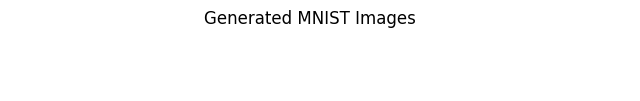

In [20]:
import matplotlib.pyplot as plt

def plot_images(images, title="Generated Images"):
    # Visualize the sampled images
    images = images.view(-1, 28, 28).detach().cpu().numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Sampling
print("Sampling from model...")
sampled_images = trainer.sample(x_shape=(8, 1, 28, 28))  # 8 개의 이미지를 샘플링
plot_images(sampled_images, title="Generated MNIST Images")